# Extraction of Collocated Imagery from Public and BYOC Collections

In [1]:
import os

# define repo name and get root working directory
repo = 'byoc-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\byoc-api'

### _Setup imports and configuration_

In [2]:
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

# Initialize SentinelHubBYOC class
config = SHConfig()
byoc = SentinelHubBYOC(config=config)

In [3]:
# get pathname to configuration file
cfg_file = os.path.join( os.path.join( root_path, 'cfg' ), 'fusion/s2-timeseries-outputs.yml' )
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            datasource: "byoc",
                            bands: ["B1", "B2"],
                        },
                        {
                            datasource: "s2_l2a",
                            bands: [ "B02", "B03", "B04", "SCL" ],
                        } ],
                        output: [
                            { id: "B1", bands: 1, sampleType: SampleType.UINT16 },
                            { id: "TrueColor", bands: 3 },
                            { id: "SCL", bands: 1, sampleType: SampleType.UINT16 } ]
                    }
                }
                function evaluatePixel(samples) {  
                
                    var s1 = samples.byoc[0]
                    var s2 = samples.s2_l2a[0]
                
                    var truecolor = [ s2.B04, s2.B03, s2.B02 ]
         

In [4]:
import yaml
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

### _Define Area of Interest covering Isle of Portland_

In [5]:
# setup aoi limits and resolution
coords = 530575, 5595700, 547118, 5606883
resolution = 30

In [6]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [7]:
# get utm bbox
bbox = client.getBoundingBox( coords, src_crs=CRS(32630) )
print ( bbox, bbox.crs.value )

530575.0,5595700.0,547118.0,5606883.0 32630


In [8]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(551, 373)

### _Pick timeframe encompassing BYOC time series_

In [9]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2021, 9, 1, 0, 0, 0 ), 
                'end' : datetime( 2021, 11, 7, 23, 59, 59 ) }
timeframe

{'start': datetime.datetime(2021, 9, 1, 0, 0),
 'end': datetime.datetime(2021, 11, 7, 23, 59, 59)}

In [10]:
# get S1 acquisitions between start / end dates satisfying filter conditions
client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

[datetime.datetime(2021, 9, 7, 0, 0, tzinfo=tzutc())]

### _Get BYOC extract fused with spatially and temporally collocated Sentinel-2 imagery_

In [11]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

,TrueColor.tif,B1.tif,SCL.tif,time
0,"[[[3, 7, 9], [3, 7, 9], [3, 7, 8], [3, 7, 8], ...","[[7320, 7303, 7308, 7298, 7276, 7312, 7289, 72...","[[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,...",2021-09-07 00:00:00+00:00


In [12]:
# apply scaling
import numpy as np

data = response._df[ 'B1.tif' ][ 0 ]

mean = np.mean( response._df[ 'B1.tif' ][ 0 ] )
std = np.std( response._df[ 'B1.tif' ][ 0 ] )

data = np.clip( data, mean - ( std * 3 ), mean + ( std * 3 ) )
response._df[ 'B1.tif' ].loc[ 0 ] = data

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


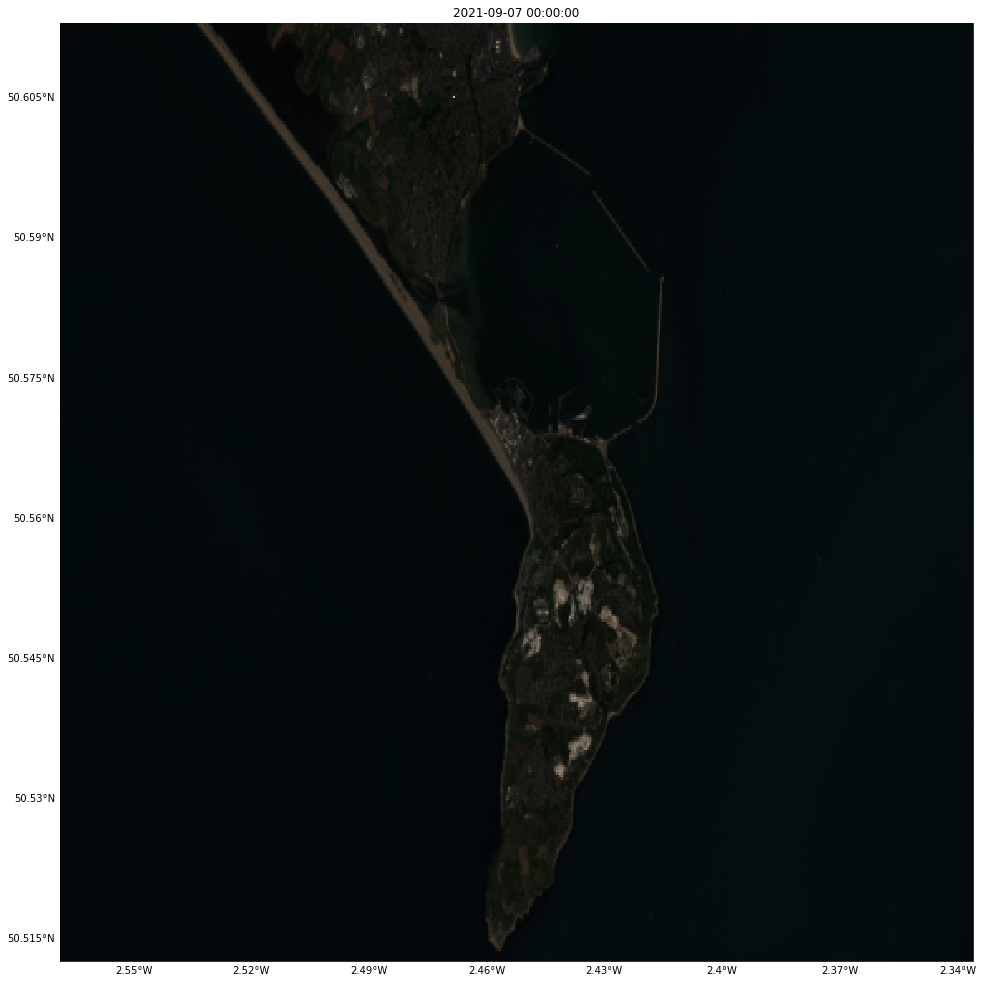

In [13]:
# plot sentinel-2 rgb image
response.plotImages( 'TrueColor.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 } )

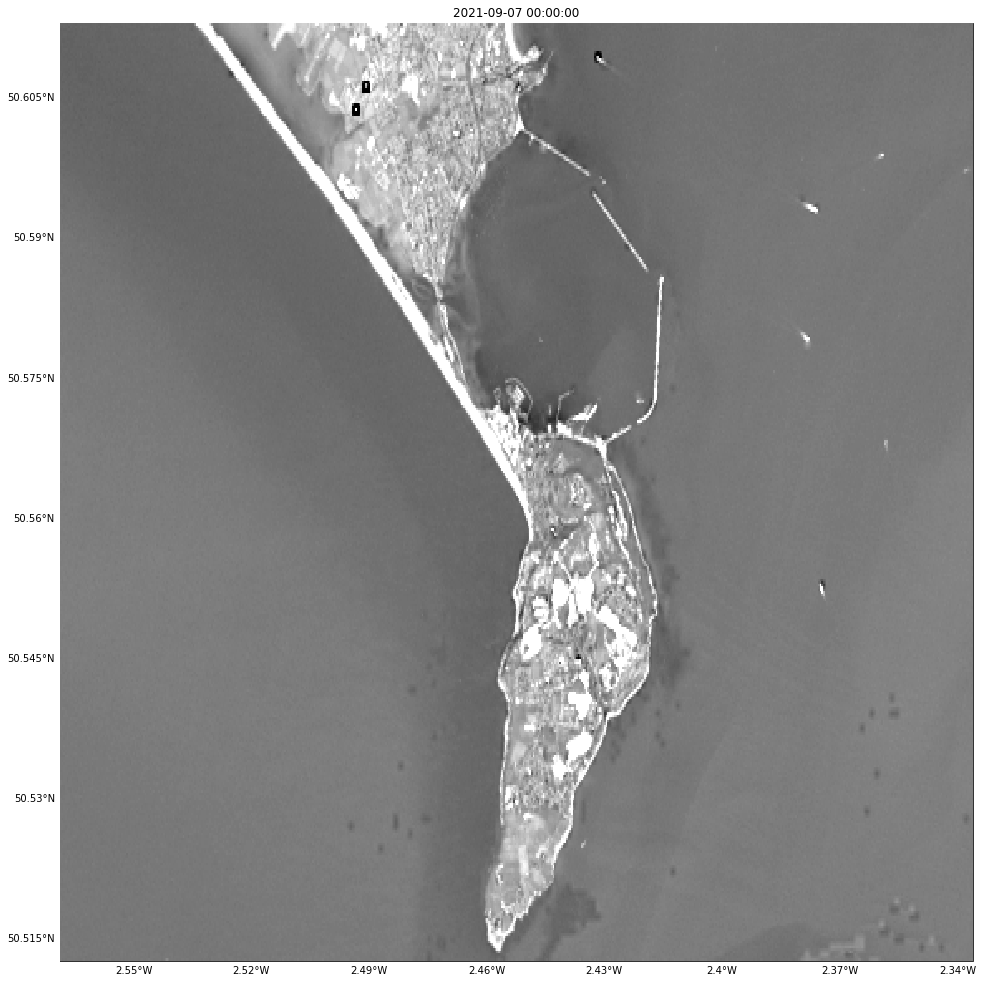

In [14]:
response.plotImages( 'B1.tif', alpha={ 'data' : 1.0, 'grid' : 0.0 }, cmap='gray' )

C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


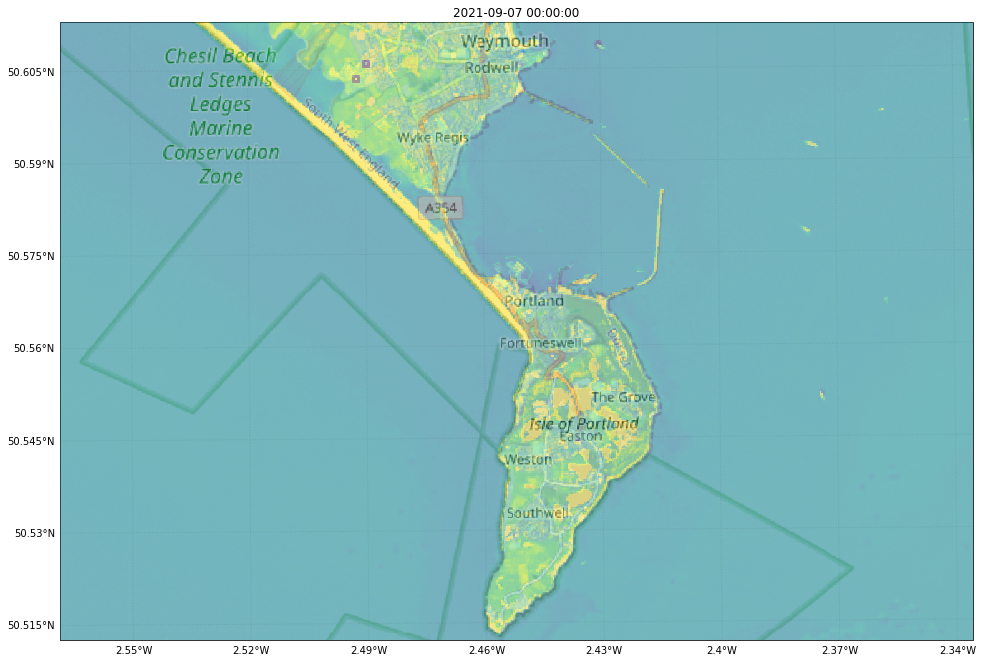

In [15]:
response.plotImages( 'B1.tif', osm_zoom=12, alpha={ 'data' : 0.4, 'grid' : 0.3 } )